In [1]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
DATA_PATH = ''
#HISTORY_PATH = "Voter_History_{0}"
PREPROCESSED_PATH = "data/NewYork/newyork_preprocessed_20160511.csv"
COUPLES_PATH="data/NewYork/couples/all_couples_20121231.csv"
#COUPLES_PATH="couples/{0}/couples_FLA_{0}.csv"

In [3]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--old', dest='old_date', action='store', type=str, help='old date value')
parser.add_argument('--new', dest='new_date', action='store', type=str, help='new date value')

args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--old OLD_DATE] [--new NEW_DATE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/rahullachh/.local/share/jupyter/runtime/kernel-f8cdca1a-3b16-4ef0-af82-deb06150a3e0.json


SystemExit: 2

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
#preprocessed_date = args.new_date
preprocessed_date = str(20160511)

In [5]:
#couples_date = args.old_date
couples_date = str(20121231)

In [6]:
image_file_prefix = "newyork_" +  couples_date + "_" + preprocessed_date
stat_file_prefix = "newyork_" +  couples_date + "_" + preprocessed_date

import os
if not os.path.exists("plots/" + image_file_prefix):
    os.makedirs("plots/" + image_file_prefix)

if not os.path.exists("stats/" + stat_file_prefix):
    os.makedirs("stats/" + stat_file_prefix)
    
stat_file_path = "stats/" + stat_file_prefix + "/"

In [7]:
global_df = pd.read_csv(PREPROCESSED_PATH.format(preprocessed_date) , sep='\t')

In [8]:
global_df.head()

,last_name,first_name,house_number,residence_apartment,residence_street_name,residence_city,residence_zip_code_5,dob,gender,political_party,county_code,voter_status_codes,unique_nys_voter_id,age,uniq_addr
0,duffy,christopher,6506,101a,vosburgh rd,altamont,12009.0,19890227,M,BLK,1,ACTIVE,NY000000000020585350,27,6506 101a vosburgh rd altamont 120090
1,johnson,d andre,5,19,okara dr,schenectady,12303.0,19890926,M,DEM,1,PURGED,NY000000000020585433,26,5 19 okara dr schenectady 123030
2,tolive,michael,345,338,northern blvd,albany,12204.0,19230822,M,REP,1,PURGED,NY000000000020585599,92,345 338 northern blvd albany 122040
3,duffek,margaret,6720,32,state rte,greenville,12083.0,19240329,F,DEM,1,PURGED,NY000000000020585828,92,6720 32 state rte greenville 120830
4,foskey,shirley,51,1,judson st,albany,12206.0,19470302,F,DEM,1,ACTIVE,NY000000000020586140,69,51 1 judson st albany 122060


In [9]:
req_cols = ['last_name', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [10]:
global_df.isnull().sum()

last_name                0
first_name               0
house_number             0
residence_apartment      0
residence_street_name    0
residence_city           0
residence_zip_code_5     0
dob                      0
gender                   0
political_party          0
county_code              0
voter_status_codes       0
unique_nys_voter_id      0
age                      0
uniq_addr                0
dtype: int64

In [11]:
global_df.shape

(5908472, 15)

In [12]:
couples_df = pd.read_csv(COUPLES_PATH.format(couples_date) , sep='\t')

In [13]:
couples_df[["uniq_addr"]].head()

,uniq_addr
0,7 7c elm ave delmar 120540
1,3 1a winding brook dr guilderland 120840
2,790 9w us rte glenmont 120770
3,50 3 main st cohoes 120470
4,285 2h colonie st albany 122100


In [14]:
global_df.columns

Index(['last_name', 'first_name', 'house_number', 'residence_apartment',
       'residence_street_name', 'residence_city', 'residence_zip_code_5',
       'dob', 'gender', 'political_party', 'county_code', 'voter_status_codes',
       'unique_nys_voter_id', 'age', 'uniq_addr'],
      dtype='object')

In [15]:
couples_df.columns

Index(['last_name_L', 'first_name_L', 'house_number_L',
       'residence_apartment_L', 'residence_street_name_L', 'residence_city_L',
       'residence_zip_code_5_L', 'dob_L', 'gender_L', 'political_party_L',
       'county_code_L', 'voter_status_codes_L', 'unique_nys_voter_id_L',
       'age_L', 'uniq_addr', 'last_name_R', 'first_name_R', 'house_number_R',
       'residence_apartment_R', 'residence_street_name_R', 'residence_city_R',
       'residence_zip_code_5_R', 'dob_R', 'gender_R', 'political_party_R',
       'county_code_R', 'voter_status_codes_R', 'unique_nys_voter_id_R',
       'age_R', 'age_diff'],
      dtype='object')

In [17]:
addr_df = global_df[["unique_nys_voter_id","uniq_addr"]]

## Collecting Addresses of voters

In [18]:
couples_df_found = pd.merge(couples_df, addr_df, left_on=["unique_nys_voter_id_L"], right_on=["unique_nys_voter_id"], suffixes=["","_L"])

In [19]:
del couples_df_found['unique_nys_voter_id']

In [20]:
couples_df_found = pd.merge(couples_df_found, addr_df, left_on=["unique_nys_voter_id_R"], right_on=["unique_nys_voter_id"], suffixes=["","_R"])

### Removing extra column generated of voter id

In [21]:
del couples_df_found['unique_nys_voter_id']

In [22]:
couples_df_found[["unique_nys_voter_id_L","unique_nys_voter_id_R", "uniq_addr_L","uniq_addr_R"]].head()

,unique_nys_voter_id_L,unique_nys_voter_id_R,uniq_addr_L,uniq_addr_R
0,NY000000000020715661,NY000000000020715745,3 1a winding brook dr guilderland 120840,3 1a winding brook dr guilderland 120840
1,NY000000000020712493,NY000000000022544710,790 9w us rte glenmont 120770,790 129 us route 9w glenmont 120770
2,NY000000000020715862,NY000000000020752725,50 3 main st cohoes 120470,50 3 main st cohoes 120470
3,NY000000000020715878,NY000000000053064860,285 2h colonie st albany 122100,285 2h colonie st albany 122100
4,NY000000000020880332,NY000000000039945666,2568 28 western ave altamont 120090,2568 28 western ave altamont 120090


In [23]:
couples_df_found['separated'] = couples_df_found.apply(lambda x : x.uniq_addr_L != x.uniq_addr_R, axis=1)

## Separation percentage

In [24]:
couples_df_found['separated'].value_counts()

False    622018
True     157640
Name: separated, dtype: int64

In [25]:
couples_df_found['separated'].value_counts()/couples_df_found['separated'].shape

False    0.797809
True     0.202191
Name: separated, dtype: float64

In [26]:
global_df['uniq_addr'].unique().shape

(3982640,)

In [27]:
couples_df_found.head()

,last_name_L,first_name_L,house_number_L,residence_apartment_L,residence_street_name_L,residence_city_L,residence_zip_code_5_L,dob_L,gender_L,political_party_L,...,gender_R,political_party_R,county_code_R,voter_status_codes_R,unique_nys_voter_id_R,age_R,age_diff,uniq_addr_L,uniq_addr_R,separated
0,marotta,joseph,3,1-a,winding brook dr,guilderland,12084.0,19621002,M,REP,...,F,DEM,1,ACTIVE,NY000000000020715745,50,0,3 1a winding brook dr guilderland 120840,3 1a winding brook dr guilderland 120840,False
1,hayes,nancy,790,9w,us rte,glenmont,12077.0,19371028,F,REP,...,F,DEM,1,ACTIVE,NY000000000022544710,75,0,790 9w us rte glenmont 120770,790 129 us route 9w glenmont 120770,True
2,conklin,melody,50,3,main st,cohoes,12047.0,19830128,F,GRE,...,M,BLK,1,ACTIVE,NY000000000020752725,29,0,50 3 main st cohoes 120470,50 3 main st cohoes 120470,False
3,ramos,mila,285,2h,colonie st,albany,12210.0,19830212,F,DEM,...,M,DEM,1,ACTIVE,NY000000000053064860,29,0,285 2h colonie st albany 122100,285 2h colonie st albany 122100,False
4,sisenstein,justin,2568,2-8,western ave,altamont,12009.0,19850320,M,DEM,...,F,DEM,1,PURGED,NY000000000039945666,27,0,2568 28 western ave altamont 120090,2568 28 western ave altamont 120090,False


## Logging total separation percentage in file

In [28]:
stat_file_path

'stats/newyork_20121231_20160511/'

In [29]:
total_separated_couples = couples_df_found[couples_df_found["separated"] == True].shape[0]
with open(stat_file_path + "total_separation_percentage.csv", "w") as f:
    f.write("\t".join(["separated_count", "total_count", "percentage"]) + "\n")
    f.write("\t".join([str(total_separated_couples), str(couples_df_found.shape[0]), str(100.0 * total_separated_couples/couples_df_found.shape[0])]))

## Feature wise separation percentage

In [30]:
cols = ["political_party", "gender"]
unique_dic = {}
for c in cols:
    unique_dic[c] = set(global_df[c].unique())

## Demographic Percentages

In [31]:
party_affiliation_counts = {}
race_counts = {}

party_affiliation_percentages = {}
race_percentages = {}

total = global_df.shape[0]
for cat_value in unique_dic["political_party"]:
    party_affiliation_counts[cat_value] = global_df[global_df["political_party"] == cat_value].shape[0]
    party_affiliation_percentages[cat_value] = 100.0 * global_df[global_df["political_party"] == cat_value].shape[0]/total


## Thresholding Demographics
For Party affiliation we stick to 5%

In [32]:
party_percent_threshold = 5.0
party_other_groups = []
for cat_value in party_affiliation_percentages:
    if party_affiliation_percentages[cat_value] <= party_percent_threshold:
        party_other_groups.append(cat_value)

# TODO

In [33]:
# TODO: Implement others mapping into global and couples dataframe
# def create_others_df()

In [34]:
global_df.shape

(5908472, 15)

In [35]:
print(str(unique_dic))

{'political_party': {'CON', 'DEM', 'REP', 'BLK', 'OTH', 'WEP', 'REF', 'WOR', 'GRE', 'IND'}, 'gender': {'U', 'M', 'F'}}


## Generate Pair-wise stats by feature
Current focus is only on gender/race/political-affiliation

In [36]:
import time
from itertools import combinations 

def generate_category_based_on_pair_values(first_val, second_val):
    return "({0}, {1})".format(str(first_val), str(second_val))

def generate_pair_stats_by_feature(global_df, couples_df_found, feature, stats={}, others=[]):
    print("Collecting uniques by feature: " + feature)
    unique_vals = list(global_df[feature].unique())
    cat_combinations = list(combinations(list(unique_vals), 2))
    
    stats[feature] = {}
    print("Processing : " + feature + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    start_time = time.time()
    stats[feature]["Other Categories"] = {'count': 0, 'total': 0}
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[feature + "_L"] == first_val) & (couples_df_found[feature + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[feature + "_L"] == second_val) & (couples_df_found[feature + "_R"] == first_val)]
        
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        if first_val in others or second_val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += left_right.shape[0] + right_left.shape[0]
            continue
        
        stat["total"] = left_right.shape[0] + right_left.shape[0]
        stat["percent"] = count * 100.0/(left_right.shape[0] + right_left.shape[0])
        
        category = generate_category_based_on_pair_values(first_val, second_val)
        stats[feature][category] = stat
        
        i += 1
        
    print("Total value combinations process: " + str(i) + " Total time (secs): " + str(time.time() - start_time))
    
    print("Processing symmetric combinations: " + feature + " : Total comb: " + str(len(unique_vals)))
    for val in unique_vals:
        subset = couples_df_found[(couples_df_found[feature + "_L"] == val) & (couples_df_found[feature + "_R"] == val)]
        
        count = subset[subset["separated"] == True].shape[0]
        
        if val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += subset.shape[0]
            continue
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        stat["total"] = subset.shape[0]
        stat["percent"] = count * 100.0/(subset.shape[0])
        
        category = generate_category_based_on_pair_values(val, val)
        stats[feature][category] = stat
        
    if len(others) > 0 and stats[feature]["Other Categories"]["count"] > 0:
        stats[feature]["Other Categories"]["percent"] = 100.0 * stats[feature]["Other Categories"]["count"]/stats[feature]["Other Categories"]["total"]
    else:
        del stats[feature]["Other Categories"]
    
    print("Done with processing feature: " + feature)
    
    return stats

In [37]:
stat_file_path

'stats/newyork_20121231_20160511/'

In [38]:
def plot_pairwise_stat_by_feature(feature, stats, total_couples=1):
    feature_stats = stats[feature]
    
    figures, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    
    percent_stats = []
    pair_combinations = []
    totals = []
    
    for pair_comb in feature_stats:
        percent_stats.append(feature_stats[pair_comb]["percent"])
        totals.append(feature_stats[pair_comb]["total"])
        pair_combinations.append(pair_comb)

    plot_df = pd.DataFrame({"percent": percent_stats, "category_combination": pair_combinations, "totals": totals})
    plot_df["category_combination_percentage"] = 100.0*plot_df["totals"]/total_couples
    
    sns.barplot(x="percent", y="category_combination", data=plot_df, ax=axes[0], palette=sns.color_palette("Set2"))
    
    axes[0].set(xlabel="Separation percentage")
    
    #     sns.barplot(x="category_combination_percentage", y="category_combination", palette=sns.color_palette("Set2"), data=plot_df, ax=axes[1])

    #   Pie chart
    labels = pair_combinations
    sizes = plot_df["category_combination_percentage"].tolist()
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=['teal', 'salmon', 'silver', 'lightblue', 'orchid', 'pink', 'lightgreen', 'wheat'])
    axes[1].axis('equal')
    axes[1].set(xlabel="Category percentage out of total couples")
    
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    
    #     axes[0].set_title(feature)
    #     axes[1].set_title(feature + " wise couple proportion")

    #     Writing stats into file
    stat_file_name = feature + "_totalCouples-" + str(total_couples) + ".csv"
    plot_df.to_csv(stat_file_path + stat_file_name, sep="\t")
        
    plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix +  "_pairwise_stat_" + feature)
    plt.tight_layout()

In [39]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "political_party", others=party_other_groups)

Processing : political_party : Total comb: 45
Total value combinations process: 3 Total time (secs): 10.584253311157227
Processing symmetric combinations: political_party : Total comb: 10
Done with processing feature: political_party


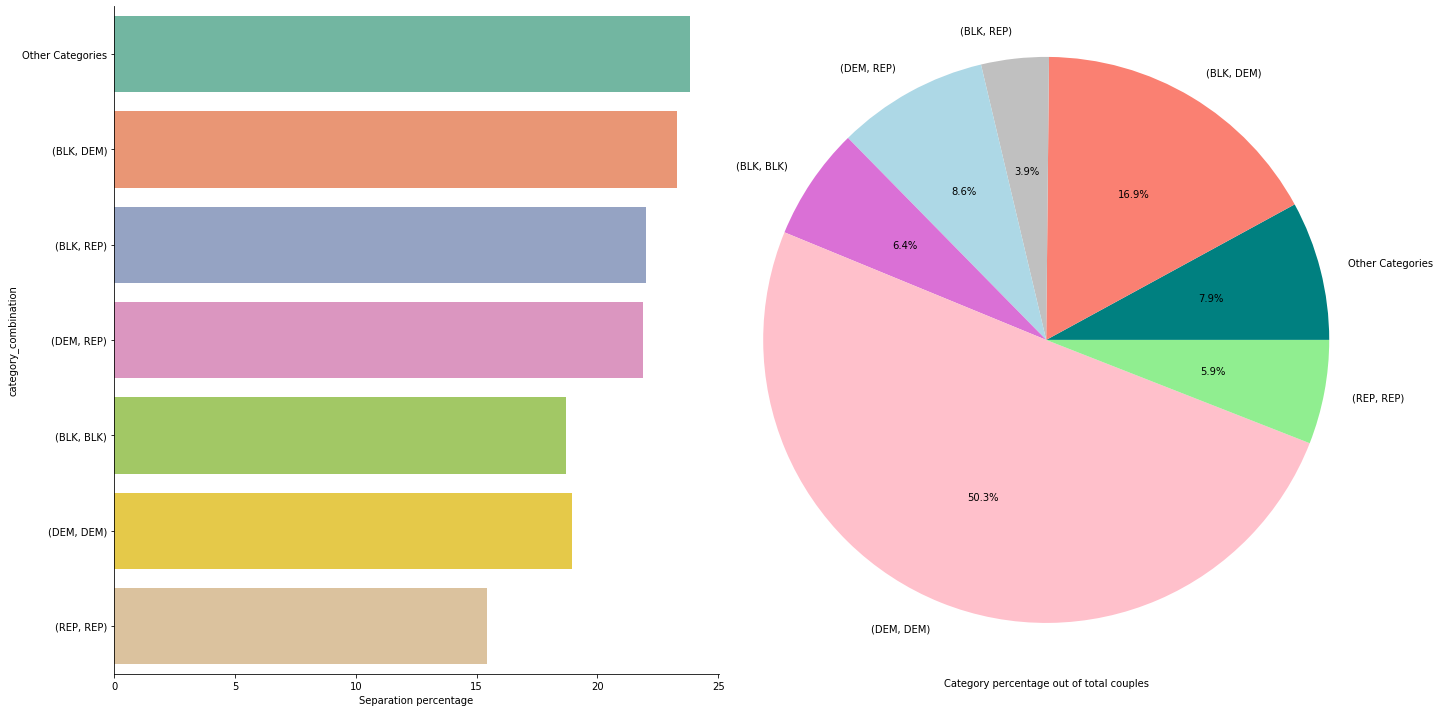

In [40]:
plot_pairwise_stat_by_feature("political_party", stats, total_couples=couples_df_found.shape[0])

In [41]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "gender", others=party_other_groups)

Processing : gender : Total comb: 3
Total value combinations process: 3 Total time (secs): 1.1694614887237549
Processing symmetric combinations: gender : Total comb: 3
Done with processing feature: gender


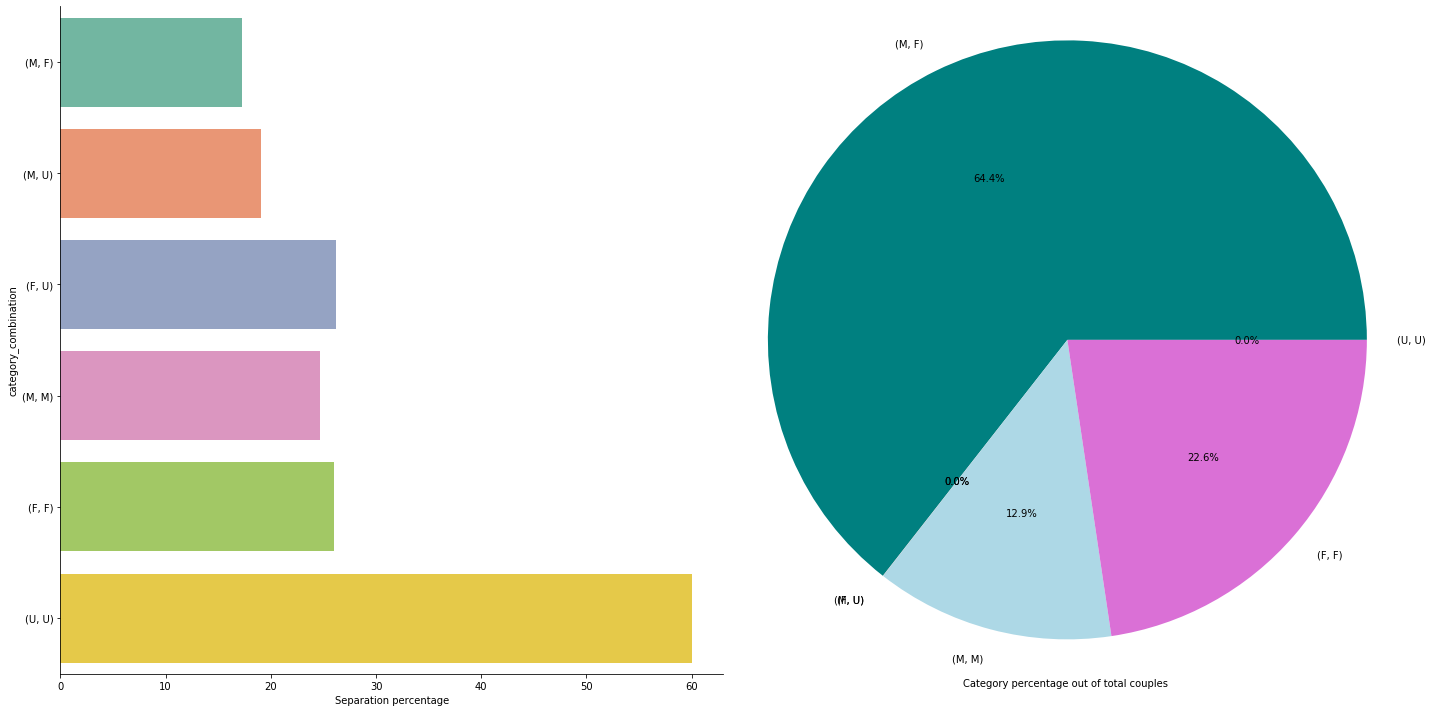

In [42]:
plot_pairwise_stat_by_feature("gender", stats, total_couples=couples_df_found.shape[0])

In [43]:
stats

{'political_party': {'Other Categories': {'count': 14764,
   'total': 61966,
   'percent': 23.825969079817966},
  '(BLK, DEM)': {'count': 30663,
   'total': 131721,
   'percent': 23.27874826337486},
  '(BLK, REP)': {'count': 6622, 'total': 30095, 'percent': 22.003655092208007},
  '(DEM, REP)': {'count': 14752,
   'total': 67432,
   'percent': 21.876853719302407},
  '(BLK, BLK)': {'count': 9397, 'total': 50225, 'percent': 18.70980587356894},
  '(DEM, DEM)': {'count': 74292,
   'total': 391860,
   'percent': 18.958811820548156},
  '(REP, REP)': {'count': 7150,
   'total': 46359,
   'percent': 15.423110938544834}},
 'gender': {'(M, F)': {'count': 86773,
   'total': 502389,
   'percent': 17.272074030283306},
  '(M, U)': {'count': 8, 'total': 42, 'percent': 19.047619047619047},
  '(F, U)': {'count': 16, 'total': 61, 'percent': 26.229508196721312},
  '(M, M)': {'count': 24845, 'total': 100582, 'percent': 24.701238790240797},
  '(F, F)': {'count': 45995, 'total': 176579, 'percent': 26.0478312

In [44]:
couples_df_found.age_diff.unique()

array([ 0, 15,  6,  1,  8,  2,  4,  3,  5,  7,  9, 11, 12, 10, 14, 13])

In [45]:
age_diff_total_counts = couples_df_found.groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [46]:
age_diff_total_counts.head()

,age_diff,count
0,0,135848
1,1,124880
2,2,100839
3,3,78462
4,4,62360


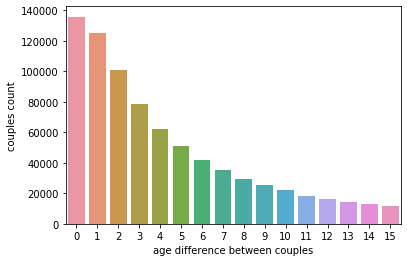

In [47]:
#plt.clear()
plt.close()
ax = sns.barplot(x="age_diff", y="count", data=age_diff_total_counts)
ax.set(xlabel='age difference between couples', ylabel='couples count')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_age_diff_aggregation")

In [48]:
age_diff_separation_stats = couples_df_found[couples_df_found["separated"]==True].groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [49]:
age_diff_separation_stats = pd.merge(age_diff_total_counts, age_diff_separation_stats, on=["age_diff"], suffixes=("_total", "_separated"))

In [50]:
age_diff_separation_stats["percent"] = 100.0 * age_diff_separation_stats["count_separated"]/age_diff_separation_stats["count_total"]

In [51]:
age_diff_separation_stats

,age_diff,count_total,count_separated,percent
0,0,135848,29135,21.446764
1,1,124880,23766,19.031070
2,2,100839,19141,18.981743
3,3,78462,14873,18.955673
4,4,62360,11827,18.965683
5,5,51140,9895,19.348846
6,6,41679,8272,19.846925
7,7,35307,7215,20.435041
8,8,29197,6097,20.882282
9,9,25141,5445,21.657850


In [52]:
age_diff_separation_stats.to_csv(stat_file_path + "age_diff_separation_stats.csv", sep='\t', header=["age_diff", "counts_of_that_age_diff", "separated_count", "separated_percentage"])

In [53]:
stat_file_path

'stats/newyork_20121231_20160511/'

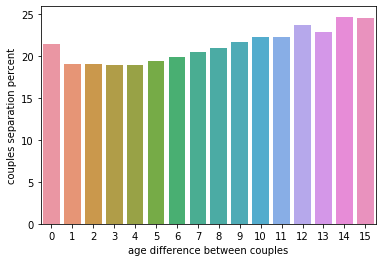

In [54]:
ax = sns.barplot(x="age_diff", y="percent", data=age_diff_separation_stats, )
ax.set(xlabel='age difference between couples', ylabel='couples separation percent')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_age_diff_separation_percentages")

In [55]:
couples_df_found.dtypes

last_name_L                 object
first_name_L                object
house_number_L              object
residence_apartment_L       object
residence_street_name_L     object
residence_city_L            object
residence_zip_code_5_L     float64
dob_L                        int64
gender_L                    object
political_party_L           object
county_code_L                int64
voter_status_codes_L        object
unique_nys_voter_id_L       object
age_L                        int64
uniq_addr                   object
last_name_R                 object
first_name_R                object
house_number_R              object
residence_apartment_R       object
residence_street_name_R     object
residence_city_R            object
residence_zip_code_5_R     float64
dob_R                        int64
gender_R                    object
political_party_R           object
county_code_R                int64
voter_status_codes_R        object
unique_nys_voter_id_R       object
age_R               